# The differential drive simulation



A differential drive robot can be modeled as a unicycle for the purpose of simplifying control and planning algorithms. This abstraction is particularly useful in mobile robotics to represent the robot's kinematics in a more manageable form.
A differential drive robot has two independently driven wheels mounted on the same axis. The kinematic equations for the linear velocity $( v )$ and angular velocity $ (\omega) $ are given by:

\begin{equation}
v = \frac{r}{2} (\omega_r + \omega_l)
\end{equation}

\begin{equation}
\omega = \frac{r}{L} (\omega_r - \omega_l)
\end{equation}

where:
\( r \) is the radius of the wheels,
\( L \) is the distance between the wheels,
$( \omega_r )$ and $( \omega_l )$ are the angular velocities of the right and left wheels, respectively.


### Unicycle Model
A unicycle model simplifies the robot to a single point with a heading direction. The kinematics of a unicycle are described by its linear velocity $( v )$  and angular velocity $ (\omega) $:

\begin{equation}
\dot{x} = v \cos(\theta)
\end{equation}

\begin{equation}
\dot{y} = v \sin(\theta)
\end{equation}

\begin{equation}
\dot{\theta} = \omega
\end{equation}

where \( (x, y) \) is the position of the robot and $( \theta )$ is its orientation.

### Mapping Differential Drive to Unicycle
To treat a differential drive robot as a unicycle, we use the kinematic equations of the differential drive to define the linear and angular velocities of the unicycle model.

Given the differential drive velocities \( v \) and \( \omega \):

\begin{align}
v &= \frac{r}{2} (\omega_r + \omega_l) \\
\omega &= \frac{r}{L} (\omega_r - \omega_l)
\end{align}

We can now substitute these into the unicycle model equations:

\begin{align}
\dot{x} &= \left(\frac{r}{2} (\omega_r + \omega_l)\right) \cos(\theta) \\
\dot{y} &= \left(\frac{r}{2} (\omega_r + \omega_l)\right) \sin(\theta) \\
\dot{\theta} &= \frac{r}{L} (\omega_r - \omega_l)
\end{align}

These equations describe the motion of the differential drive robot in terms of the unicycle model, allowing for easier analysis and control.
By modeling a differential drive robot as a unicycle, we can leverage simpler kinematic equations for control and planning. This abstraction maintains the essential characteristics of the robot's motion while simplifying the mathematical treatment.
The following function are the main simulation of the real system, in the move_real function v_std and w_std are meant to include the real non linear fenomena. 




In [167]:
def move_real(x, dt, u,v_std,w_std):
    v_act = u[0] + randn()*v_std
    w_act = u[1] + randn()*w_std
    theta = x[4]
    
    x[5]=w
    x[1]=v_act * cos(theta)
    x[3]=w_act * sin(theta) 
    
    x[0],x[2],x[4]=runge_kutta((x[0],x[2],x[4]),[v_act,w_act],dt)

    return x 

def kinematic_model(state, control, dt):
    x, y, theta = state
    v, omega = control

    dx = v * cos(theta)
    dy = v * sin(theta)
    dtheta = omega

    return np.array([dx, dy, dtheta])

def runge_kutta(state, control, dt):
    k1 = kinematic_model(state, control, dt)
    k2 = kinematic_model(state + 0.5 * dt * k1, control, dt)
    k3 = kinematic_model(state + 0.5 * dt * k2, control, dt)
    k4 = kinematic_model(state + dt * k3, control, dt)

    new_state = state + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
    return new_state

## Design the Controllers

For our robot we will implement two different type of control:

-Input-output Linearization

-posture regulation

For each of them a class has been defined with the necessary function

In [168]:
from math import sin, cos
import numpy as np

class InputOutputLinearization:
    def __init__(self, f_s=100, b=0.05, k1=1, k2=1, epsilon=0.025):
    
        self.f_s = f_s
        self.b = b
        self.k1 = k1
        self.k2 = k2
        self.epsilon = epsilon       
        
    def compute_control_input(self, state, des_position, des_speed):
        x, y, theta = state
        y1 = x + self.b * cos(theta)
        y2 = y + self.b * sin(theta)
        y1_d, y2_d = des_position
        y1_dot_d, y2_dot_d = des_speed

        u1 = y1_dot_d + self.k1 * (y1_d - y1)
        u2 = y2_dot_d + self.k2 * (y2_d - y2)

        T = np.array([[np.cos(theta), -self.b*np.sin(theta)],
                      [np.sin(theta), self.b*np.cos(theta)]])
        T_inv = np.linalg.inv(T)
        v, omega = np.dot(T_inv, np.array([u1, u2]))
        
        return v, omega / 2

class PostureRegulation:
    def __init__(self, f_s=10, k1=1, k2=1, k3=1, epsilon=0.05,epsilon_angle = 10):
        self.goal_reached = False
        self.desired_position = None
        self.f_s = f_s
        self.k1 = k1
        self.k2 = k2
        self.k3 = k3
        self.epsilon = epsilon
        self.epsilon_angle = epsilon_angle*3.14/180

    def compute_polar_coordinates(self):
        x_d, y_d, theta=  self.desired_position
        c=cos(theta)
        s=sin(theta)
        A=np.array([[c,  s, 0, -c*x_d-s*y_d],
           [-s, c, 0, s*x_d-c*y_d],
           [0,  0, 0, 0],
           [0,  0, 0, 1]])
        x, y, _, _ = np.dot(np.array([self.estimed_pos[0], self.estimed_pos[1], 0,1]),A.T)
        theta = self.estimed_pos[2]-theta
        #print(f'[PostureRegulation.compute_polar_coordinates] x: {x} / y : {y} / theta : {theta}')
        rho = np.sqrt(x**2+y**2)
        if abs(y) < 0.001 or abs(x) < 0.001:
            gamma = np.arctan2(y, x) - theta - np.pi
        else:
            gamma = np.arctan2(y, x) - theta + np.pi
        delta = gamma + theta
        return rho, gamma, delta

    def compute_control_input(self):
        rho, gamma, delta = self.compute_polar_coordinates()
        v = self.k1 * rho * cos(gamma)
        try:
            omega = self.k2 * gamma + self.k1 * sin(gamma) * cos(gamma) * (1 + self.k3 * delta / gamma)
        except ZeroDivisionError:
            omega = 0
        return v, omega

    def control_to_point(self,pos,des_pos):
        self.desired_position=des_pos
        current_state = self.estimed_pos=pos
        if np.linalg.norm(np.array(current_state[0:2]) - np.array(self.desired_position[0:2])) < self.epsilon and abs(current_state[2] - self.desired_position[2]) < self.epsilon_angle:
            self.goal_reached = True
        else:
            v, omega = self.compute_control_input()
            return(v,omega)

## Design the State Estimators

For our robot we will consider the position and orientation with their variables

$$\mathbf x = \begin{bmatrix}x & \dot x & y & \dot y & \theta & \dot \theta\end{bmatrix}^\mathsf{T}$$

Five estimatoras has been implemented and compared:

-Runge-kutta 2-order

-Euler integration

-Runge-kutta 4-order

-Linear Kalman Filter

-Unscented Kalman Filter

The control input $\mathbf{u}$ is the commanded linear velocity and the commanded angular velocity or the x-velocity y-velocity and angular velocity (For lthe linear Kalman filter)

$$\mathbf{u} = \begin{bmatrix}v & \omega\end{bmatrix}^\mathsf{T}$$

$$\mathbf{u} = \begin{bmatrix}\dot x & \dot y & \omega\end{bmatrix}^\mathsf{T}$$


In [169]:
from scipy.linalg import inv,block_diag
from filterpy.common import Q_discrete_white_noise
from math import tan, sin, cos
from numpy.random import randn
import numpy as np
import matplotlib.pyplot as plt
from filterpy.stats import plot_covariance


class KF_DD:
    def __init__(self,x = np.array([0.,0.,0.,0.,0.,0.]),P=np.diag([.01,.01,.01,.01,.01,.01]),R_var=0.01,Q_var=0.01,dt=0.01):
        self.x = x.T
        self.P = P
        self.F = np.array([[1, dt, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0, 0],
                            [0, 0, 1, dt, 0, 0],
                            [0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 1, dt],
                            [0, 0, 0, 0, 0, 0]])
        self.B = np.array([[0, 0 ,0],
                            [1, 0 ,0],
                            [0, 0 ,0],
                            [0, 1 ,0],
                            [0, 0 ,0],
                            [0, 0 ,1]])
        self.H = self.B.T
        self.R= np.diag([R_var,R_var,R_var])
        self.Q = block_diag(Q_discrete_white_noise(2, dt=dt, var=Q_var), 
                            Q_discrete_white_noise(2, dt=dt, var=Q_var), 
                            Q_discrete_white_noise(2, dt=dt, var=Q_var))
        self.dt = dt
        self.K=[]
          
        
    def predict(self, u):
        self.x = self.F @ self.x + self.B @ u
        self.P = self.F @ self.P @ self.F.T + self.Q
    
    def update(self, z):
        S = self.H @ self.P @ self.H.T + self.R
        self.K = self.P @ self.H.T @ inv(S)
        y = z - self.H @ self.x
        self.x += self.K @ y
        self.P = self.P - self.K @ self.H @ self.P

def runge_kutta_estimator(x, dt, u):
    v = u[0] 
    w = u[1] 
    theta = x[4]
    x[5]=w
    x[1]=v * cos(theta)
    x[3]=v * sin(theta) 
    
    x[0],x[2],x[4]=runge_kutta((x[0],x[2],x[4]),[v,w],dt)

    return x 

def runge_kutta_2_estimator(x, dt, u):
    v = u[0] 
    w = u[1] 
    theta = x[4]
    
    x[0]+= v*dt*cos(theta + (w*dt/2))
    x[1]=v * cos(theta)
    x[2]+= v*dt*sin(theta + (w*dt/2))
    x[3]=v * sin(theta) 
    x[4]+= w*dt
    x[5]=w

    return x 

def euler_approximation(x, dt, u):
    v = u[0] 
    w = u[1] 
    theta = x[4]
    
    x[0]+= v*dt*cos(theta)
    x[1]=v * cos(theta)
    x[2]+= v*dt*sin(theta)
    x[3]=v * sin(theta) 
    x[4]+= w*dt
    x[5]=w

    return x 

In [170]:
from filterpy.kalman import unscented_transform, MerweScaledSigmaPoints
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.common import Q_discrete_white_noise
from scipy.linalg import block_diag

def residual(a, b):
    y = a - b
    return y

def state_mean(sigmas, Wm):
    x = np.zeros(6)
    x[0] = np.sum(np.dot(sigmas[:, 0], Wm))
    x[1] = np.sum(np.dot(sigmas[:, 1], Wm))
    x[2] = np.sum(np.dot(sigmas[:, 2], Wm))
    x[3] = np.sum(np.dot(sigmas[:, 3], Wm))
    x[4] = np.sum(np.dot(sigmas[:, 4], Wm))
    x[5] = np.sum(np.dot(sigmas[:, 5], Wm))
    return x

def z_mean(sigmas, Wm):
    z_count = sigmas.shape[1]
    x = np.zeros(z_count)
    x[0] = np.sum(np.dot(sigmas[:,0], Wm))
    x[1] = np.sum(np.dot(sigmas[:,1], Wm))
    return x

def Hx(x):
    """ takes a state variable and returns the measurement
    that would correspond to that state. """
    v=np.sqrt(x[1]**2+x[3]**2) 
    w=x[5]
    return np.array([v,w])

def move(x, dt, u,v_std,w_std):
    v_act = u[0]
    w_act = u[1] 
    theta = x[4]
    
    x[5]=w
    x[1]=v_act * cos(theta)
    x[3]=w_act * sin(theta) 
    
    x[0],x[2],x[4]=runge_kutta((x[0],x[2],x[4]),[v_act,w_act],dt)

    return x 

def unscented_KF(init_pos=[0,0,0,0,0,0],P=[.01,.01,.01,.01,.005,.005],sigma_v=0.01,sigma_w=0.01,alpha=.00001,dt=0.01,proc_noise_vr=0.1):
    points = MerweScaledSigmaPoints(n=6, alpha=alpha, beta=2, kappa=3-6, subtract=residual)
    ukf = UKF(dim_x=6, dim_z=2, fx=move, hx=Hx, dt=dt, points=points, x_mean_fn=state_mean, z_mean_fn=z_mean, residual_x=residual, residual_z=residual)

    ukf.x = np.array(init_pos)
    ukf.P = np.diag(P)
    ukf.R = np.diag([sigma_v**2,sigma_w**2])
    ukf.Q = block_diag(Q_discrete_white_noise(2, dt=dt, var=proc_noise_vr),
                       Q_discrete_white_noise(2, dt=dt, var=proc_noise_vr),
                       Q_discrete_white_noise(2, dt=dt, var=proc_noise_vr))
    return(ukf)
    

## Posture regulation Simulation
In the following simulation, the linear kalman filter was used, and there is also a saturation on the maximum linear and angular velocity, in order to better simulate the real hardware condition.

goal reached: True


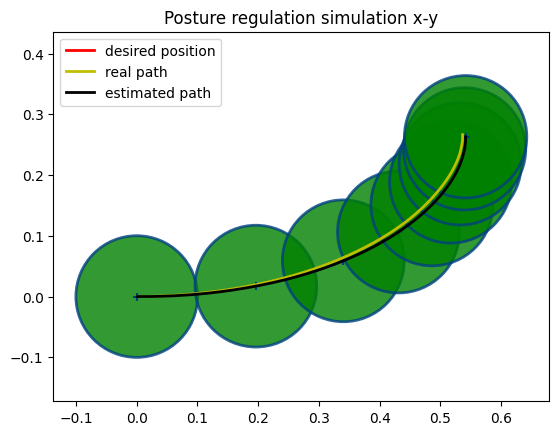

In [171]:
#Simulation variable
fs=25
dt=1/fs
initial_pos= np.array([0.,0.,0.,0.,0.,0.])
v_var=0.05
w_var=0.05
v_max=0.2
w_max=0.2
des_pos=[0.5,0.3,np.pi/2]

#KF
P=np.diag([.01,.02,.01,.02,.01,.02])
R_var=0.2
Q_var=0.1
KF=KF_DD(dt=dt,x = initial_pos,P=P,R_var=R_var,Q_var=Q_var)

#Controller
controller=PostureRegulation(f_s=fs, k1=0.5, k2=0.5, k3=10, epsilon=0.05,epsilon_angle = 5)

#Auxiliary variable
sim_pos=initial_pos.copy()
xs, cov, track= [], [], []
plt.figure()
i=0

while i<5000: #security reason
    
    xs.append(KF.x)
    cov.append(KF.P)
    track.append(list(sim_pos))
    
    try:
        v,w=controller.control_to_point(pos=[sim_pos[0],sim_pos[2],sim_pos[4]],des_pos=des_pos)
    except: 
        print("goal reached:",controller.goal_reached )
        break
    
    #Check on real limitation
    if v>v_max:
        v=v_max
    elif v<-v_max:
        v=-v_max
    if w>w_max:
        w=w_max
    elif w<-w_max:
        w=-w_max
        
    u=[v*cos(KF.x[4]),v*sin(KF.x[4]),w]

    #Real system
    for j in range(10): 
        sim_pos=move_real(sim_pos, dt/10, u=[v,w], v_std=v_var, w_std=w_var)
      

    #prediction step
    KF.predict(u)
    
    #mesurement
    z=np.array([sim_pos[1],sim_pos[3],sim_pos[5]])+np.array([R_var*randn(),R_var*randn(),R_var*randn()])
    
    #update step
    KF.update(z)
    
    #Plot the covariance on x and y every fs step
    if i%(fs)==0:
        cova =np.diag([KF.P[0,0],KF.P[2,2]])
        cova[0,1]=KF.P[0,2]
        cova[1,0]=KF.P[2,0]
        plot_covariance((KF.x[0], KF.x[2]), cov=cova,facecolor='g', alpha=0.8) 

    i+=1

KF, controller=[], []
xs, cov = np.array(xs), np.array(cov)
track = np.array(track)

#plot
plt.plot(des_pos[0], des_pos[1], label='desired position', color='r', lw=2)
plt.plot(track[:, 0], track[:,2],label='real path', color='y', lw=2)
plt.plot(xs[:, 0], xs[:,2],label='estimated path', color='k', lw=2)
plt.legend()
plt.axis('equal')
plt.title("Posture regulation simulation x-y")
plt.show()

Let's see the error along the trajectory

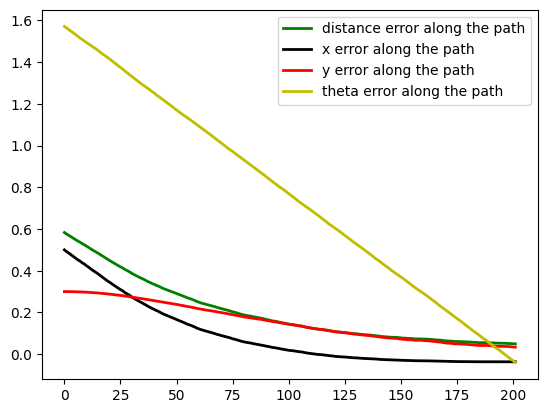

In [172]:
plt.figure()
plt.plot(np.sqrt((des_pos[0]-track[:, 0])**2+(des_pos[1]-track[:, 2])**2), label='distance error along the path', color='g', lw=2)
plt.plot(des_pos[0]-track[:, 0], label='x error along the path', color='k', lw=2)
plt.plot(des_pos[1]-track[:, 2], label='y error along the path', color='r', lw=2)
plt.plot(des_pos[2]-(track[:, 4]%(2 * np.pi)), label='theta error along the path', color='y', lw=2)
plt.legend()
plt.show()

## INPUT OUTPUT LINEARIZATION SIMULATIONS

### Define the common trajectory
Using the trajectory_planner library we created, we initialise a fixed trajectory on which to compare different types of state estimators. 
To ensure more consistent simulations, the random's seed is fixed.
trajectory scaling was applied on the trajectories.


In [173]:
from trajectory_planning.trajectory_planner import *
#path generation
path = [(initial_pos[0], initial_pos[2]),(-.6, -.7), (-.6, 0), (-.4, .6), (0, .5), (0, -.2), (-.2, -.6), (.3, -.5), (.3, .6), (.6, .4)]
TP = TrajectoryPlanner(np.zeros((100, 100)), path_list=path)
v_max=0.1
w_max=0.1
x_des, y_des, x_dot_des, y_dot_des, theta_des, theta_dot_des = TP.cartesian_traj(f_s=fs, profile=CUBIC_POL_PROF,trajectory_scaling=True,max_v=v_max,max_w=w_max)

#Simulation variable
fs=20
dt=1/fs
initial_pos= np.array([0.,0.,0.,0.,0.,0.])

v_var=0.02
w_var=0.1

### INPUT OUTPUT LINEARIZATION with UKF

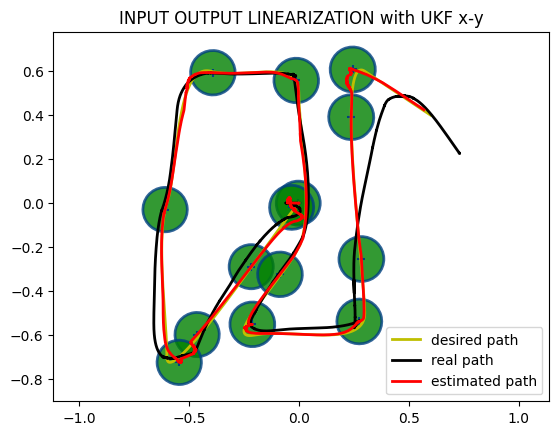

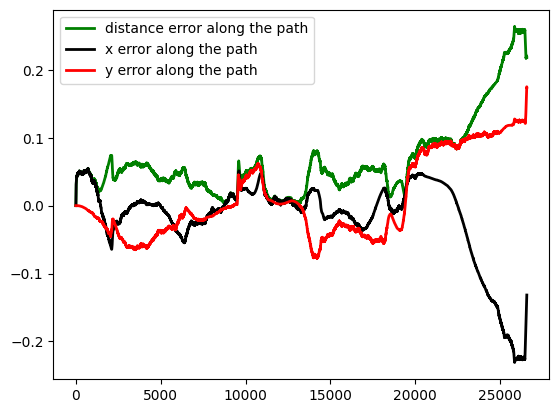

In [174]:
#UKF variable
P=[.01,.2,.01,.02,.005,.01]
Q_var=0.01
alpha=0.00001
ukf=unscented_KF(init_pos=initial_pos,P=P,sigma_v=v_var,sigma_w=w_var,alpha=alpha,dt=dt,proc_noise_vr=Q_var)

#Controller definition
controller=InputOutputLinearization()

#Auxiliary variable
sim_pos=initial_pos.copy()
xs, cov, track, inputs= [], [], [],[]
plt.figure()

np.random.seed(40)

for i in range(len(x_des)):
    xs.append(ukf.x)
    cov.append(ukf.P)
    track.append(list(sim_pos))

    v,w=controller.compute_control_input([ukf.x[0],ukf.x[2],ukf.x[4]], [x_des[i],y_des[i]], [x_dot_des[i],y_dot_des[i]])
    inputs.append([v,w])
    
    #real system
    for j in range(10): 
        sim_pos=move_real(sim_pos, dt/10, u=[v,w], v_std=v_var, w_std=w_var)
      
    #prediction step
    ukf.predict(u=[v,w],v_std=v_var,w_std=w_var)

    #mesurement
    z=np.array([np.sqrt(sim_pos[1]**2+sim_pos[3]**2),sim_pos[5]])+np.array([v_var*randn(),w_var*randn()])
    
    #update step
    ukf.update(z)
    
    #Plot the covariance on x and y every fs step
    if i%(100*fs)==0:
        cova =np.diag([ukf.P[0,0],ukf.P[2,2]])
        cova[0,1]=ukf.P[0,2]
        cova[1,0]=ukf.P[2,0]
        plot_covariance((ukf.x[0], ukf.x[2]), cov=cova,facecolor='g', alpha=0.8) 
    
ukf, controller=[], []

xs, cov = np.array(xs), np.array(cov)
track = np.array(track)

#plots
plt.plot(x_des, y_des, label='desired path', color='y', lw=2)
plt.plot(track[:, 0], track[:,2],label='real path', color='k', lw=2)
plt.plot(xs[:, 0], xs[:,2],label='estimated path', color='r', lw=2)
plt.legend()
plt.axis('equal')
plt.title("INPUT OUTPUT LINEARIZATION with UKF x-y")
plt.show()

plt.figure()
plt.plot(np.sqrt((x_des-track[:, 0])**2+(y_des-track[:, 2])**2), label='distance error along the path', color='g', lw=2)
plt.plot(x_des-track[:, 0], label='x error along the path', color='k', lw=2)
plt.plot(y_des-track[:, 2], label='y error along the path', color='r', lw=2)
plt.legend()
plt.show()

### INPUT OUTPUT LINEARIZATION with Linear KF

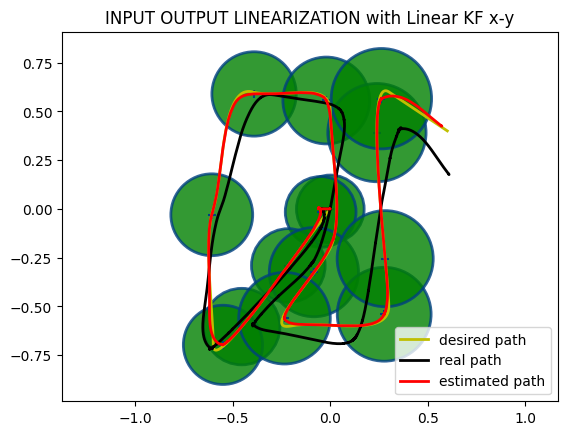

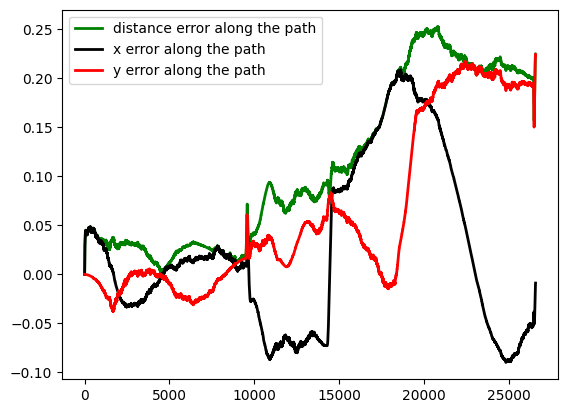

In [180]:
#KF variable
P=3*np.diag([.01,.02,.01,.02,.01,.02])
R_var=0.02
Q_var=0.1
KF=KF_DD(dt=dt,x = initial_pos,P=P,R_var=R_var,Q_var=Q_var)

#Controller definition
controller=InputOutputLinearization()

#Auxiliary variable
sim_pos=initial_pos.copy()
xs, cov, track, inputs= [], [], [],[]
plt.figure()

np.random.seed(42)

for i in range(len(x_des)):
    xs.append(KF.x)
    cov.append(KF.P)
    track.append(list(sim_pos))

    v,w=controller.compute_control_input([KF.x[0],KF.x[2],KF.x[4]], [x_des[i],y_des[i]], [x_dot_des[i],y_dot_des[i]])
    u=[v*cos(KF.x[4]),v*sin(KF.x[4]),w]
    inputs.append([v,w])
    
    #real system
    for j in range(10): 
        sim_pos=move_real(sim_pos, dt/10, u=[v,w], v_std=v_var, w_std=w_var)
      
    #prediction step
    KF.predict(u)

    #mesurement
    z=np.array([sim_pos[1],sim_pos[3],sim_pos[5]])+np.array([R_var*randn(),R_var*randn(),R_var*randn()])
    
    #update step
    KF.update(z)
    
    #Plot the covariance on x and y every fs step
    if i%(100*fs)==0:
        cova =np.diag([KF.P[0,0],KF.P[2,2]])
        cova[0,1]=KF.P[0,2]
        cova[1,0]=KF.P[2,0]
        plot_covariance((KF.x[0], KF.x[2]), cov=cova,facecolor='g', alpha=0.8) 
    
KF, controller=[], []

xs, cov = np.array(xs), np.array(cov)
track = np.array(track)

#plots
plt.plot(x_des, y_des, label='desired path', color='y', lw=2)
plt.plot(track[:, 0], track[:,2],label='real path', color='k', lw=2)
plt.plot(xs[:, 0], xs[:,2],label='estimated path', color='r', lw=2)
plt.legend()
plt.axis('equal')
plt.title("INPUT OUTPUT LINEARIZATION with Linear KF x-y")
plt.show()

plt.figure()
plt.plot(np.sqrt((x_des-track[:, 0])**2+(y_des-track[:, 2])**2), label='distance error along the path', color='g', lw=2)
plt.plot(x_des-track[:, 0], label='x error along the path', color='k', lw=2)
plt.plot(y_des-track[:, 2], label='y error along the path', color='r', lw=2)
plt.legend()
plt.show()

Let us compare the v and w obtained by the planner with those performed by the wheeled.

We observe how the i/o linearisation controller to compensate for errors on the state imposes v and w that exceed the limits imposed

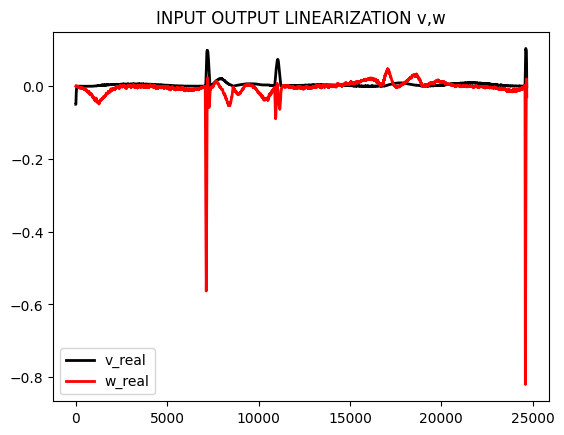

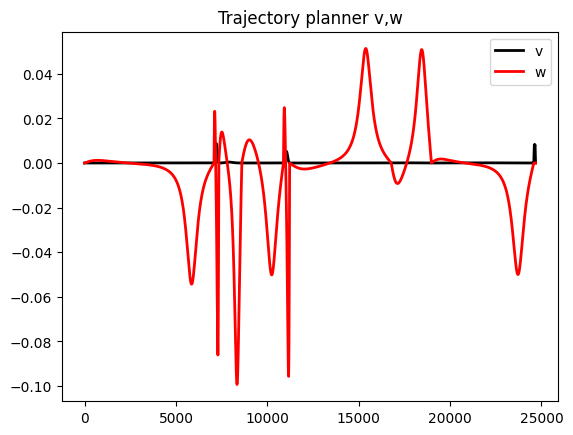

In [58]:
plt.figure()
plt.plot([elem for elem, _ in inputs], label='v_real', color='k', lw=2)
plt.plot([elem for _,elem in inputs], label='w_real', color='r', lw=2)
plt.legend()
plt.title("INPUT OUTPUT LINEARIZATION v,w")
plt.show()

plt.figure()
plt.plot(np.array(x_dot_des)**2+np.array(y_dot_des)**2, label='v', color='k', lw=2)
plt.plot(theta_dot_des, label='w', color='r', lw=2)
plt.legend()
plt.title("Trajectory planner v,w")
plt.show()

### INPUT OUTPUT LINEARIZATION with Runge-Kutta-4

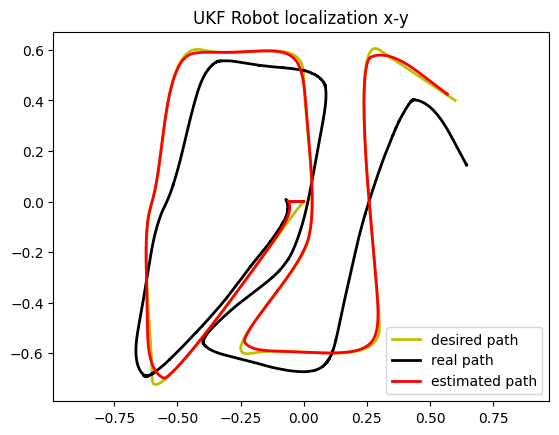

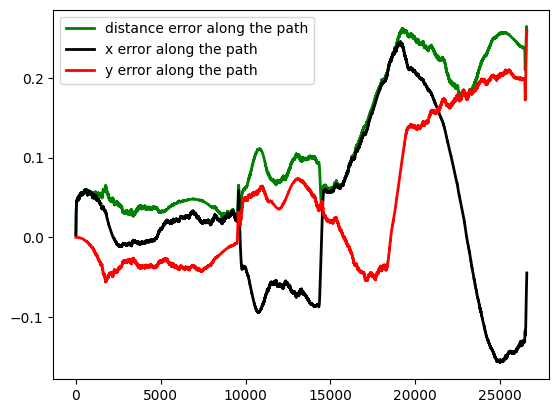

In [176]:
#Control
controller=InputOutputLinearization()

#Auxiliary variable
x_est=initial_pos.copy()
sim_pos=initial_pos.copy()
xs, track= [], []
xs.append(list(x_est))
plt.figure()

np.random.seed(42)

for i in range(len(x_des)):
    
    u=controller.compute_control_input([x_est[0],x_est[2],x_est[4]], [x_des[i],y_des[i]], [x_dot_des[i],y_dot_des[i]])

    #real system
    for j in range(10): 
        sim_pos=move_real(sim_pos, dt/10, u=u, v_std=v_var, w_std=w_var)
    track.append(list(sim_pos))  

    x_est=move_real(x_est, dt, u=u, v_std=0., w_std=0.)
    xs.append(list(x_est))
    
controller=[]

xs= np.array(xs)
track = np.array(track)

#plots
plt.plot(x_des, y_des, label='desired path', color='y', lw=2)
plt.plot(track[:, 0], track[:,2],label='real path', color='k', lw=2)
plt.plot(xs[:, 0], xs[:,2],label='estimated path', color='r', lw=2)
plt.legend()
plt.axis('equal')
plt.title("UKF Robot localization x-y")
plt.show()

plt.figure()
plt.plot(np.sqrt((x_des-track[:, 0])**2+(y_des-track[:, 2])**2), label='distance error along the path', color='g', lw=2)
plt.plot(x_des-track[:, 0], label='x error along the path', color='k', lw=2)
plt.plot(y_des-track[:, 2], label='y error along the path', color='r', lw=2)
plt.legend()
plt.show()

## Motion Planner
Using the motion_planner library we created, we are able to find the optimal path between the initial position and a goal point.

[1720714453.9763725] - prm executed in 0.059234 seconds
[1720714453.97737] - Node generation : PRM / num samples: 100 / k: 5
[1720714454.116663] - bfs executed in 0.139293 seconds
[1720714454.116663] - BFS Path: [(0, 0), (16, 6), (31, 6), (56, 15), (68, 11), (83, 26), (94, 41), (103, 43), (99, 57), (107, 75), (116, 96), (138, 90), (145, 97), (149, 99)]
[1720714454.1627069] - a_star_search executed in 0.046044 seconds
[1720714454.1627069] - A* Path: [(0, 0), (16, 6), (31, 6), (56, 15), (68, 11), (83, 26), (98, 37), (103, 43), (99, 57), (107, 75), (116, 96), (137, 96), (145, 97), (149, 99)]


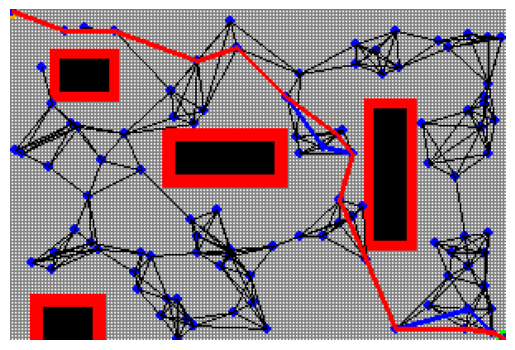

In [72]:
from motion_planning.motion_planner import *

# Initialization gridmap and Motion planning
gmap = GridMap(1, 1.5, 0.01)
gmap.add_obstacle(10, 15, (15, 15))
gmap.inflate_obstacle(1, 3)
gmap.add_obstacle(40, 10, (110, 30))
gmap.inflate_obstacle(2, 3)
gmap.add_obstacle(10, 30, (50, 40))
gmap.inflate_obstacle(3, 4)
gmap.add_obstacle(10, 15, (10, 90))
gmap.inflate_obstacle(4, 4)
gmap.draw()

# Setup app
pygame.init()
#pygame.display.set_caption('Motion Planning Graph')
width, height = gmap.shape

screen = pygame.Surface((height * CELL_SIZE, width * CELL_SIZE))
# Load background image
bg = pygame.image.load('gridmap.png')

start = (0, 0)
goal = (gmap.shape[1]-1, gmap.shape[0]-1)
motion_planner = MotionPlanner(gmap, NODE_GEN_PRM, start, goal, delta=10)


# Background
screen.blit(bg, (0, 0))
pygame.draw.circle(screen, 'orange', (start[0] * CELL_SIZE+OFFSET, start[1] * CELL_SIZE+OFFSET), 5)
pygame.draw.circle(screen, 'green', (goal[0] * CELL_SIZE+OFFSET, goal[1] * CELL_SIZE+OFFSET), 5)
motion_planner.draw_graph(screen)
motion_planner.draw_path(screen, 'bfs', 'blue')
motion_planner.draw_path(screen, 'a_star', 'red')

image = pygame.surfarray.array3d(screen)
# Matplotlib usa immagini con dimensioni (altezza, larghezza, colori), quindi dobbiamo trasporre l'array
image = np.transpose(image, (1, 0, 2))

# Show the image with matplotlib
plt.imshow(image)
plt.axis('off') 
plt.show()

#Save the result
bfs_path = [(round(x * 0.01,2), round(y * 0.01,2)) for x, y in motion_planner.bfs_path]
a_star_path = [(round(x * 0.01,2), round(y * 0.01,2)) for x, y in motion_planner.a_star_path]

Using trajectory planners, it is possible to define a single trajectory that passes through all points on the path and respects the maximum linear and angular velocity limits

In [74]:
from trajectory_planning.trajectory_planner import *

#Simulation variable
fs=20
dt=1/fs
initial_pos= np.array([0.,0.,0.,0.,0.,0.])
R_var=0.2
v_var=0.02
w_var=0.1

#path generation
path = bfs_path
TP = TrajectoryPlanner(np.zeros((100, 100)), path_list=path)
v_max=0.1
w_max=0.1
x_des, y_des, x_dot_des, y_dot_des, theta_des, theta_dot_des = TP.cartesian_traj(f_s=fs, profile=CUBIC_POL_PROF,trajectory_scaling=True,max_v=v_max,max_w=w_max)

## SIMULATION WITH I/O KF AND OBSTACLES

342300
0.0 %
0.58428279287175 %
1.1685655857435 %
1.7528483786152498 %
2.337131171487 %
2.9214139643587496 %
3.5056967572304996 %
4.08997955010225 %
4.674262342974 %
5.258545135845749 %
5.842827928717499 %
6.42711072158925 %
7.011393514460999 %
7.59567630733275 %
8.1799591002045 %
8.76424189307625 %
9.348524685948 %
9.932807478819749 %
10.517090271691497 %
11.101373064563248 %
11.685655857434998 %
12.269938650306749 %
12.8542214431785 %
13.438504236050248 %
14.022787028921998 %
14.607069821793747 %
15.1913526146655 %
15.775635407537248 %
16.359918200409 %
16.94420099328075 %
17.5284837861525 %
18.112766579024246 %
18.697049371896 %
19.281332164767747 %
19.865614957639497 %
20.449897750511248 %
21.034180543382995 %
21.61846333625475 %
22.202746129126496 %
22.78702892199825 %
23.371311714869996 %
23.955594507741747 %
24.539877300613497 %
25.124160093485248 %
25.708442886357 %
26.292725679228745 %
26.877008472100496 %
27.46129126497225 %
28.045574057843996 %
28.629856850715747 %
29.214139

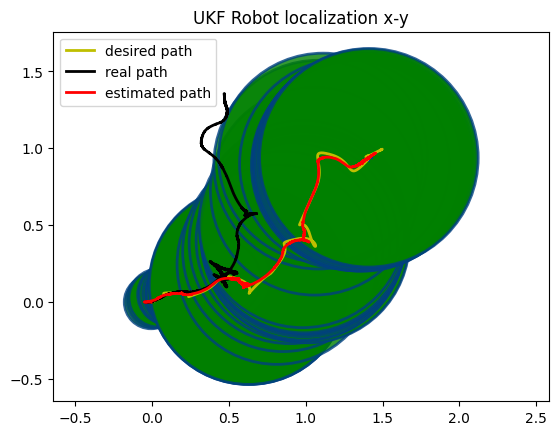

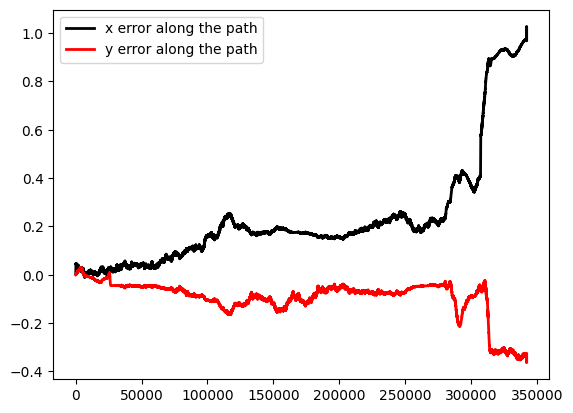

In [75]:
#KF variable
P=3*np.diag([.01,.02,.01,.02,.01,.02])
R_var=0.02
Q_var=0.1
KF=KF_DD(dt=dt,x = initial_pos,P=P,R_var=R_var,Q_var=Q_var)

#Controller
controller=InputOutputLinearization()

#Auxiliary variables
sim_pos=initial_pos
xs, cov, track= [], [], []
plt.figure()

print(len(x_des))
for i in range(len(x_des)):
    
    v,w=controller.compute_control_input([KF.x[0],KF.x[2],KF.x[4]], [x_des[i],y_des[i]], [x_dot_des[i],y_dot_des[i]])
    u=[v*cos(KF.x[4]),v*sin(KF.x[4]),w]

    #real system
    for j in range(10): 
        sim_pos=move_real(sim_pos, dt/10, u=[v,w], v_std=v_var, w_std=w_var)
    track.append(list(sim_pos))  

    #prediction step
    KF.predict(u)
 
    #Noisy mesurement
    z=np.array([sim_pos[1],sim_pos[3],sim_pos[5]])+np.array([R_var*randn(),R_var*randn(),R_var*randn()])
    
    #update step
    KF.update(z)
    
    if i%(100*fs)==0:
        print(i/len(x_des)*100,"%")
        cova =np.diag([KF.P[0,0],KF.P[2,2]])
        cova[0,1]=KF.P[0,2]
        cova[1,0]=KF.P[2,0]
        plot_covariance((KF.x[0], KF.x[2]), cov=cova,facecolor='g', alpha=0.8) 
    
    xs.append(KF.x)
    cov.append(KF.P)
 
KF,controller=[],[]

xs, cov = np.array(xs), np.array(cov)
track = np.array(track)

#plots
plt.plot(x_des, y_des, label='desired path', color='y', lw=2)
plt.plot(track[:, 0], track[:,2],label='real path', color='k', lw=2)
plt.plot(xs[:, 0], xs[:,2],label='estimated path', color='r', lw=2)
plt.legend()
plt.axis('equal')
plt.title("UKF Robot localization x-y")
plt.show()

plt.figure()
plt.plot(x_des-track[:, 0], label='x error along the path', color='k', lw=2)
plt.plot(y_des-track[:, 2], label='y error along the path', color='r', lw=2)
plt.legend()
plt.show()